# Drone Trajectory Planner

In this project, we will develop the drone trajectory planner. This notebook serves as the main file for the project, where we will refer to the instructions and demonstrate our code.

Please follow week by week instructions, which includes writing the code in the `src/` folder.

In [69]:
# Import all the files and libraries required for the project
%load_ext autoreload
%autoreload 2
import copy
    
import numpy as np

from src.camera_utils import compute_image_footprint_on_surface, compute_ground_sampling_distance, project_world_point_to_image
from src.data_model import Camera, DatasetSpec
from src.plan_computation import compute_distance_between_images, compute_speed_during_photo_capture, generate_photo_plan_on_grid
from src.visualization import plot_photo_plan

import plotly.io as pio
pio.renderers.default = 'iframe'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Week 1: Introduction

No code contribution expected this week

# Week 2: Implement data models for dataset specification and camera

For this week, we will model the dataset specification.

- Overlap: the ratio (in 0 to 1) of scene shared between two consecutive images.
- Sidelap: the ratio (in 0 to 1) of scene shared between two images in adjacent rows.
- Height: the height of the scan above the ground (in meters).
- Scan_dimension_x: the horizontal size of the rectangle to be scanned (in meters).
- Scan_dimension_y: the vertical size of the rectangle to be scanned (in meters).
- exposure_time_ms: the exposure time for each image (in milliseconds).


$\color{red}{\text{TODO: }}$ Implement `DatasetSpec` in `src/data_model.py`


In [70]:
# Model the nomimal dataset spec

overlap = 0.7
sidelap = 0.7
height = 30.48 # 100 ft
scan_dimension_x = 150
scan_dimension_y = 150
exposure_time_ms = 2 # 1/500 exposure time

dataset_spec = DatasetSpec(overlap, sidelap, height, scan_dimension_x, scan_dimension_y, exposure_time_ms)

print(f"Nominal specs: {dataset_spec}")

Nominal specs: DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2)


## Model the camera parameters

We want to model the following camera parameters in Python:
- focal length along x axis (in pixels)
- focal length along y axis (in pixels)
- optical center of the image along the x axis (in pixels)
- optical center of the image along the y axis (in pixels)
- Size of the sensor along the x axis (in mm)
- Size of the sensor along the y axis (in mm)
- Number of pixels in the image along the x axis
- Number of pixels in the image along the y axis

I recommend to use `dataclasses` ([Python documentation](https://docs.python.org/3/library/dataclasses.html), [Blog](https://www.dataquest.io/blog/how-to-use-python-data-classes/) to model these parameters.

$\color{red}{\text{TODO: }}$ Implement `Camera` in `src/data_model.py`

In [71]:
# Define the parameters for Skydio VT300L - Wide camera
# Ref: https://support.skydio.com/hc/en-us/articles/20866347470491-Skydio-X10-camera-and-metadata-overview
fx = 4938.56
fy = 4936.49
cx = 4095.5
cy = 3071.5
sensor_size_x_mm = 13.107 # single pixel size * number of pixels in X dimension
sensor_size_y_mm = 9.830 # single pixel size * number of pixels in Y dimension
image_size_x = 8192
image_size_y = 6144

camera_x10 = Camera(fx, fy, cx, cy, sensor_size_x_mm, sensor_size_y_mm, image_size_x, image_size_y)

In [72]:
print(f"X10 camera model: {camera_x10}")

X10 camera model: Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)


# Week 3: Camera Operations

We plan to write utility functions to
- project a 3D world point to an image
- Compute image footprint on a surface
- Compute the Ground Sampling Distance

## Project 3D world points into the image


![Camera Projection](assets/image_projection.png)
Reference: [Robert Collins CSE483](https://www.cse.psu.edu/~rtc12/CSE486/lecture12.pdf)


Equations to implement:
$$ x = f_x \frac{X}{Z} $$
$$ y = f_y \frac{Y}{Z} $$
$$ u = x + c_x $$
$$ v = y + c_y $$

$\color{red}{\text{TODO: }}$ Implement function `project_world_point_to_image` in `src/camera_utils.py`

In [73]:
point_3d = np.array([25, -30, 50], dtype=np.float32)
expected_uv = np.array([6564.80, 109.60], dtype=np.float32)
uv = project_world_point_to_image(camera_x10, point_3d)

print(f"{point_3d} projected to {uv}")

assert np.allclose(uv, expected_uv, atol=1e-2)

[ 25. -30.  50.] projected to [6564.7803   109.60571]


## Compute Image Footprint on the surface

We have written code to *project* a 3D point into the image. The reverse operation is reprojection, where we take $(x, y)$ and compute the $(X, Y)$ for a given value of $Z$. Note that while going from 3D to 2D, the depth becomes ambiguous so we need the to specify the $Z$.

An image's footprint is the area on the surface which is captured by the image. We can take the two corners of the image and reproject them at a given distance to obtain the width and length of the image.

$\color{red}{\text{TODO: }}$ Implement function `compute_image_footprint_on_surface` in `src/camera_utils.py`

In [74]:
footprint_at_100m = compute_image_footprint_on_surface(camera_x10, 100)
expected_footprint_at_100m = np.array([165.88, 124.46], dtype=np.float32)

print(f"Footprint at 100m = {footprint_at_100m}")

assert np.allclose(footprint_at_100m, expected_footprint_at_100m, atol=1e-2)


Footprint at 100m = [165.87831271 124.46090238]


In [75]:
footprint_at_200m = compute_image_footprint_on_surface(camera_x10, 200)
expected_footprint_at_200m = expected_footprint_at_100m * 2

print(f"Footprint at 200m = {footprint_at_200m}")

assert np.allclose(footprint_at_200m, expected_footprint_at_200m, atol=1e-2)

Footprint at 200m = [331.75662541 248.92180476]


## Ground Sampling Distance

Ground sampling distance is the length of the ground (in m) captured by a single pixel. We have the image footpring (the dimensions of ground captured by the whole sensor, and the number of pixels along the horizontal and vertical dimension. Can we get GSD from these two quantities?

Note: Please return just one value of the GSD. Take the mininum of the values along the two axes.

In [76]:
gsd_at_100m = compute_ground_sampling_distance(camera_x10, 100)
expected_gsd_at_100m = 0.0202

print(f"GSD at 100m: {gsd_at_100m}")

assert np.allclose(gsd_at_100m, expected_gsd_at_100m, atol=1e-4)

GSD at 100m: 0.020248817469059804


# Week 4: Compute Distance Between Photos

The overlap and sidelap are the ratio of the dimensions shared between two photos. We already know the footprint of a single image at a given distance. Can we convert the ratio into actual distances? And how does the distance on the surface relate to distance travelled by the camera?

$\color{red}{\text{TODO: }}$ Implement `compute_distance_between_images` in `src/plan_computation.py`



In [77]:
computed_distances = compute_distance_between_images(camera_x10, dataset_spec)
expected_distances = np.array([15.17, 11.38], dtype=np.float32)

print(f"Computed distance for X10 camera with nominal dataset specs: {computed_distances}")

assert np.allclose(computed_distances, expected_distances, atol=1e-2)

Computed distance for X10 camera with nominal dataset specs: [15.16791291 11.38070491]


$\color{red}{\text{TODO: }}$ define >=2 more specifications/camera parameters and check the computed distances. Does that align with your expections


**Scenario 1:** What happens if we change the height? How would this influence the computed distance between images?

**Intuition:** increasing the height (in this case to 100m) should increase the distance between images, as the increase of height increases the footprint

In [78]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)

dataset_spec_.height = 30.48 #default value
computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Computed distance at height {dataset_spec_.height}m: {computed_distances_}")

#Scenario 1
dataset_spec_.height = 100
computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"\nComputed distance at height {dataset_spec_.height}m: {computed_distances_}")
#As observed, distance increases with the increased height



Computed distance at height 30.48m: [15.16791291 11.38070491]

Computed distance at height 100m: [49.76349381 37.33827071]


**Scenario 2:** What happens if we change the overlap/sidelap? How would this influence the computed distance between images?

**Intuition:** decreasing overlap and sidelap (distance ratio between two images) should increase the distance in the x and y direction, as less overlap allows for distance between the image

In [79]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)

dataset_spec_.overlap, dataset_spec_.sidelap = 0.7, 0.7 #default values
computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Computed distance at overlap {dataset_spec_.overlap} and sidelap {dataset_spec_.sidelap}: {computed_distances_}")

#Scenario 2
dataset_spec_.overlap, dataset_spec_.sidelap = 0.3, 0.3
computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"\nComputed distance at overlap {dataset_spec_.overlap} and sidelap {dataset_spec_.sidelap}: {computed_distances_}")
#As expected, the computed distance increased with the decrease of the overlap/sidelap


Computed distance at overlap 0.7 and sidelap 0.7: [15.16791291 11.38070491]

Computed distance at overlap 0.3 and sidelap 0.3: [35.3917968  26.55497813]


# Week 5: Compute Maximum Speed For Blur Free Photos

To restrict motion blur due to camera movement to tolerable limits, we need to restrict the speed such that the image contents move less than 1px away. 

How much does 1px of movement translate to movement of the scene on the ground? It is the ground sampling distance!
From previous week, we know that this is the maximum movement the camera can have. 
We have the distance now. To get speed we need to divide it with time. Do we have time already in our data models?

$\color{red}{\text{TODO: }}$ Implement `compute_speed_during_photo_capture` in `src/plan_computation.py`.

In [80]:
computed_speed = compute_speed_during_photo_capture(camera_x10, dataset_spec, allowed_movement_px=1)
expected_speed = 3.09

print(f"Computed speed during photo captures: {computed_speed:.2f}m/s")

assert np.allclose(computed_speed, expected_speed, atol=1e-2)

Computed speed during photo captures: 3.09m/s


$\color{red}{\text{TODO: }}$ define >= 2more specifications/camera parameters and check the computed distances. Does that align with your expectations


**Scenario 1:** What happens if we change the exposure time? How would this influence the drone speed during photo capture?

**Intuition:** Increasing the exposure time (from default 2ms to 6ms) should allow for a *slower* drone speed during photo capture, as a higher exposure time allows the shutter to stay open longer when taking a photo, meaning that the drone travels farther for each photo. To compensate, the drone must travel slower to avoid motion blur (to keep it under the allowed pixel limit)

In [81]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)

computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Drone speed during photo capture: {computed_speed_:.2f}m/s with an exposure time of {dataset_spec_.exposure_time_ms}ms")

#Scenario 1
dataset_spec_.exposure_time_ms = 6
computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"\nDrone speed during photo capture: {computed_speed_:.2f}m/s with an exposure time of {dataset_spec_.exposure_time_ms}ms")



Drone speed during photo capture: 3.09m/s with an exposure time of 2ms

Drone speed during photo capture: 1.03m/s with an exposure time of 6ms


**Scenario 2:** What happens if we change the allowed pixel limit? How would this influence the drone speed during photo capture?

**Intuition:** Increasing the allowed pixel limit (from 1px to 3px) would cause the drone to travel at a faster speed, as the drone is allowed to travel 3x *farther* (keeping height and exposure fixed) while the camera shutter is open, comparative to the 1x distance with the default pixel limit. This could possibly lead to greater motion blur the greater the pixel limit, which could lead to adjusting other variables such as exposure and distance would be necessary to compensate

In [82]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)

allowed_movement_px = 1.0 #default
computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_, allowed_movement_px)
print(f"Drone speed during photo capture: {computed_speed_:.2f}m/s | Allowed movement pixels: {allowed_movement_px}px")

#Scenario 2
allowed_movement_px = 3.0
computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_ ,allowed_movement_px)
print(f"\nDrone speed during photo capture: {computed_speed_:.2f}m/s | Allowed movement pixels: {allowed_movement_px}px")



Drone speed during photo capture: 3.09m/s | Allowed movement pixels: 1.0px

Drone speed during photo capture: 9.26m/s | Allowed movement pixels: 3.0px


# Week 6: Generate Full Flight Plans  

We now have all the tools to generate the full flight plan.

Steps for this week:
1. Define the `Waypoint` data model. What attributes should the data model have?
   1. For Nadir scans, just the position of the camera is enough as we will always look drown to the ground.
   2. For general case (bonus), we also need to define where the drone will look at.
3. Implement the function `generate_photo_plan_on_grid` to generate the full plan.
   1. Compute the maximum distance between two images, horizontally and vertically.
   2. Layer the images such that we cover the whole scan area. Note that you need to take care when the scan dimension is not a multiple of distance between images. Example: to cover 45m length with 10m between images, we would need 4.5 images. Not possible. 4 images would not satisfy the overlap, so we should go with 5. How should we arrange 5 images in the given 45m.
   3. Assign the speed to each waypoint.

$\color{red}{\text{TODO: }}$ Implement:
- `Waypoint` in `src/data_model.py`
- `generate_photo_plan_on_grid` in `src/plan_computation.py`.

In [83]:
computed_plan = generate_photo_plan_on_grid(camera_x10, dataset_spec) 

print(f"Computed plan with {len(computed_plan)} waypoints")

Computed plan with 140 waypoints


In [84]:
MAX_NUM_WAYPOINTS_TO_PRINT = 20

for idx, waypoint in enumerate(computed_plan[:MAX_NUM_WAYPOINTS_TO_PRINT]):
    print(f"Idx {idx}: {waypoint}")
if len(computed_plan) >= MAX_NUM_WAYPOINTS_TO_PRINT:
    print("...")

Idx 0: Waypoint(x=np.float64(6.744391887513771), y=np.float64(1.0254180602006642), z=30.48, speed_mps=np.float64(3.0859197822847144), photo_trigger=True)
Idx 1: Waypoint(x=np.float64(21.9123048013996), y=np.float64(1.0254180602006642), z=30.48, speed_mps=np.float64(3.0859197822847144), photo_trigger=True)
Idx 2: Waypoint(x=np.float64(37.08021771528543), y=np.float64(1.0254180602006642), z=30.48, speed_mps=np.float64(3.0859197822847144), photo_trigger=True)
Idx 3: Waypoint(x=np.float64(52.24813062917126), y=np.float64(1.0254180602006642), z=30.48, speed_mps=np.float64(3.0859197822847144), photo_trigger=True)
Idx 4: Waypoint(x=np.float64(67.41604354305709), y=np.float64(1.0254180602006642), z=30.48, speed_mps=np.float64(3.0859197822847144), photo_trigger=True)
Idx 5: Waypoint(x=np.float64(82.58395645694291), y=np.float64(1.0254180602006642), z=30.48, speed_mps=np.float64(3.0859197822847144), photo_trigger=True)
Idx 6: Waypoint(x=np.float64(97.75186937082874), y=np.float64(1.0254180602006

## Bonus: Time computation 

if you have some time, you can implement a time computation function. We can make the drone fly as fast as possible between photos, but make sure it can decelerate back to the required speed at the photos. Please use the following data: 
- Max drone speed: 16m/s.
- Max acceleration: 3.5 m/s^2.

Hint: you might need to use a trapezoidal/triangular speed profile

![alt text](TrapezoidalNotes&Work/GeneralTrapNotes1.webp)

![alt text](TrapezoidalNotes&Work/GeneralTrapNotes2.webp)

![alt text](TrapezoidalNotes&Work/TrapFormulaRationale2.webp)

# Week 7: Visualize Flight Plans

This week, we will use a third party plotting framework called [Plotly](https://plotly.com/python/) to visualize our plans. Please follow this [tutorial](https://www.kaggle.com/code/kanncaa1/plotly-tutorial-for-beginners) to gain some basic experience with Plotly, and then come up with your own visualization function. You are free to choose to come up with your own visualization, and use something other than Plotly.

$\color{red}{\text{TODO: }}$ Implement `plot_photo_plan` in `src/visualization.py`

![alt text](FlightPlanWork/FlightPlanRationale1.webp)

![alt text](FlightPlanWork/FlightPlanRationale2.webp)

**Choices for display:** For user readability, points are generated, with a line going through the points to represent the drone travel. The start and end points are colored so it is clear to the user the drone's direction of travel. Additionally, the offset tries to account for fitting the image in the dotted rectangle (scan area) so that images taken are optimized and stay relatively within the rectangular scan area.

**NOTE:** It seems that users have issue viewing the actual plotly express graph so I provided the image, if you would like to see values such as velocity and position, please run the notebook cell to generate the plotly graph for yourself.

In [113]:
import plotly.io as pio
import math
from src.visualization import plot_profiling


pio.renderers.default = "vscode" #default was not working with iframe renderer so switched to vscode renderer
computed_plan = generate_photo_plan_on_grid(camera_x10, dataset_spec) 

fig = plot_photo_plan(computed_plan, dataset_spec)
fig.show()

DRONE_ACC = 3.5 #mps^2
DRONE_MAX_VEL = 16 #mps
point_to_observe = 1 #has to be greater or equal to 1

dist = math.hypot(float(computed_plan[point_to_observe].x - computed_plan[point_to_observe - 1].x), float(computed_plan[1].y - computed_plan[0].y))
v_blur = compute_speed_during_photo_capture(camera_x10, dataset_spec) 

prof_fig = plot_profiling(dist, DRONE_ACC, v_blur, DRONE_MAX_VEL)
prof_fig.show()


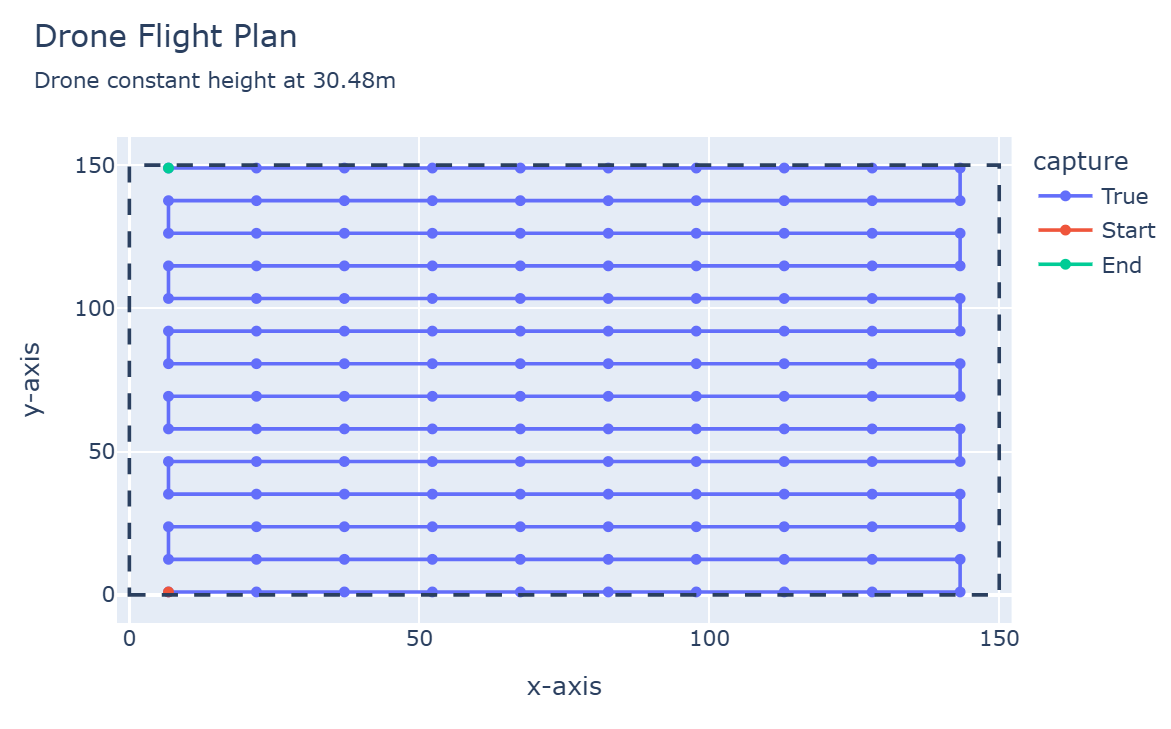

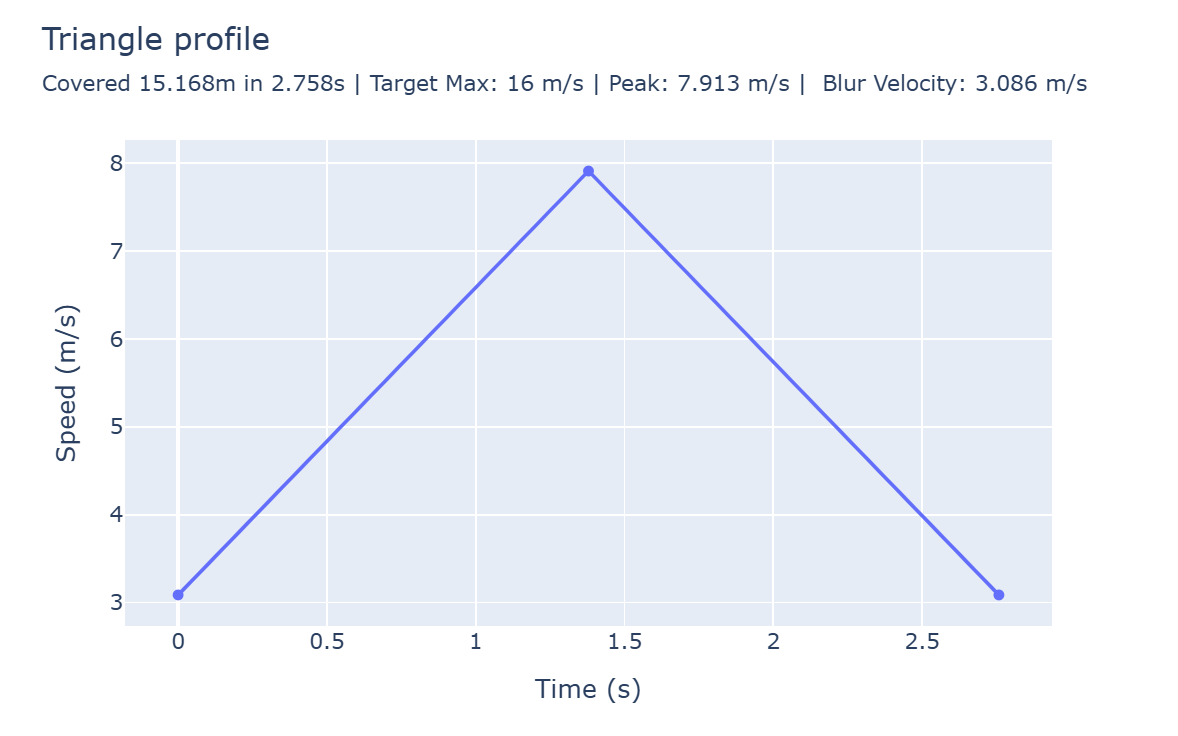

**Intuition:** At 16 m/s for max velocity, the graph displays a triangular profiling of the velocity graph. If we experiment and lower the max velocity (lower to 7 m/s), we can observe that a trapezoidal profile will be generated because there is enough time to accelerate, cruise, then decelerate. 

In [110]:
DRONE_ACC = 3.5 #mps^2
DRONE_MAX_VEL = 7 #mps

prof_fig = plot_profiling(dist, DRONE_ACC, v_blur, DRONE_MAX_VEL)
prof_fig.show()

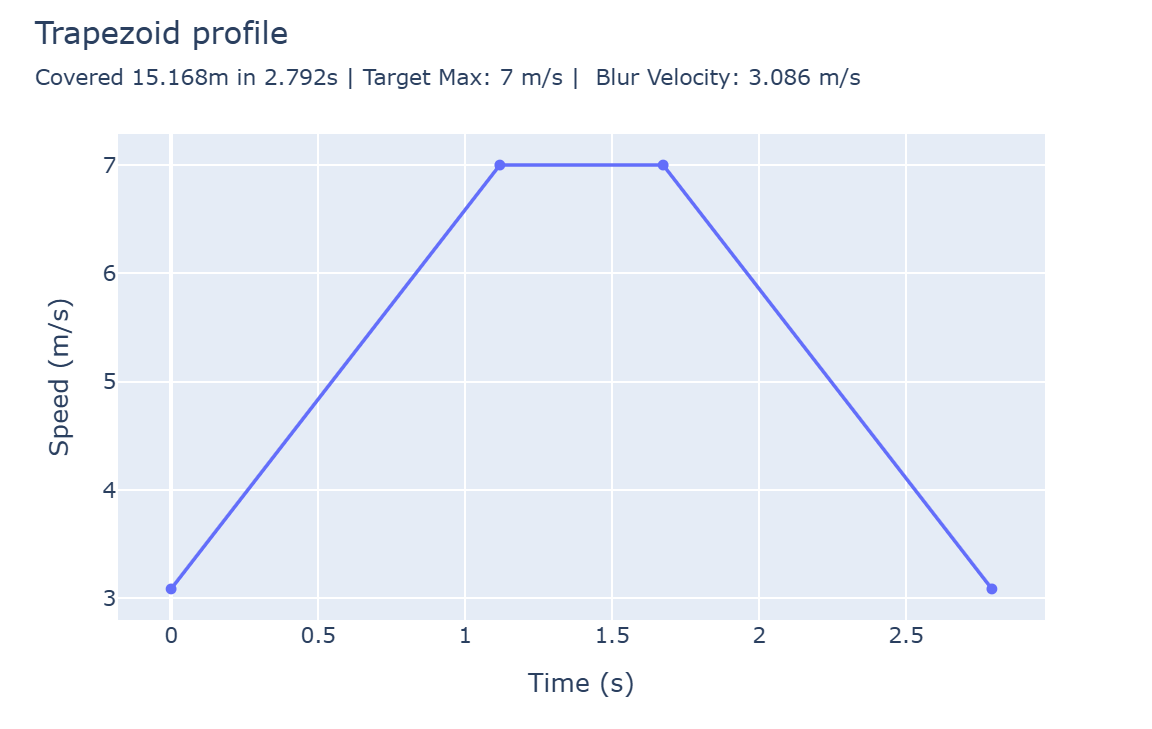

$\color{red}{\text{TODO: }}$ Perform the following experiments (and any other you can think of) where we change just one parameter of the input camera/dataset specification and observe the change in the output plan. 

1. Change overlap and confirm it affects the consecutive images
2. Change sidelap and confirm it does not affect the consecutive images
3. Change the height of the scan and document the affect on scan plans
4. Change exposure time

Each experiment should specify: 
1. Input params you are changing
2. Impact you observe
3. explanation behind the change in output (intuition based or a text explanation is preffered over using equations)
4. Practical implication of the correlation: how can I drone pilot use this result

In [107]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)

dataset_spec_.exposure_time_ms = 1000

print(camera_, dataset_spec_)
print(f"Original speed (2ms): {compute_speed_during_photo_capture(camera_x10, dataset_spec)}\nNew Speed (1000ms): {compute_speed_during_photo_capture(camera_x10, dataset_spec_)}")

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), dataset_spec)
fig.show()

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144) DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=1000)
Original speed (2ms): 3.0859197822847144
New Speed (1000ms): 0.006171839564569429


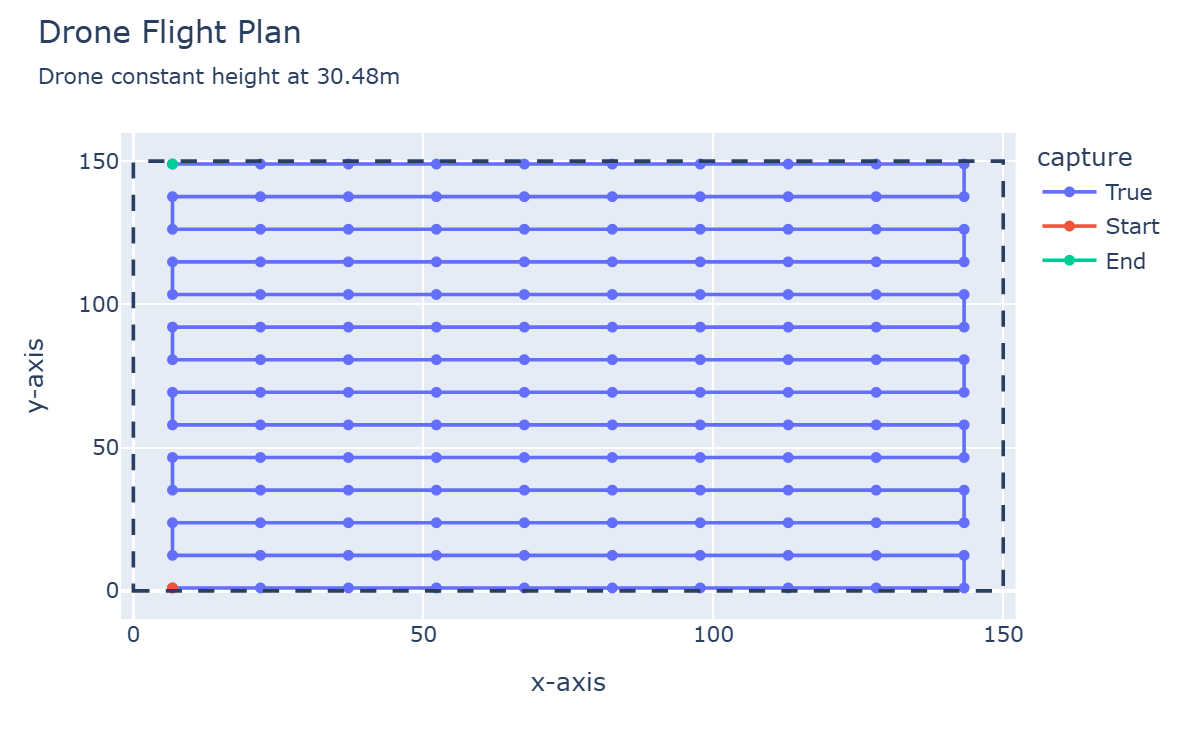

**Scenario 1:** What happens if we change the sidelap? How about overlap? How would this influence our drone planner?

**Intuition:** When both sidelap are overlap are decreased, drone waypoints are more spread out, as the images can be taken further apart (less overlay on the images)

Sidelap - less points on the x-direction (horizontally)

Overlap - less points on the y-direction (vertically)

In [ ]:
dataset_spec_.sidelap = 0.6
fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), dataset_spec)
fig.show()

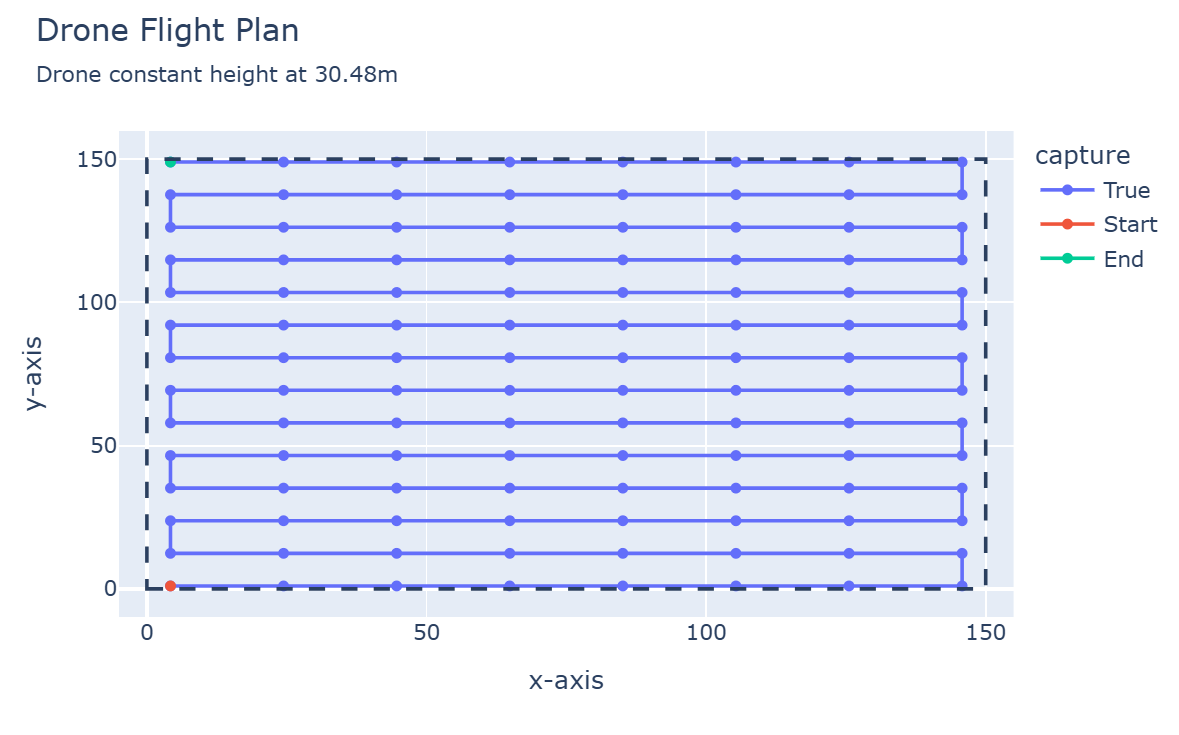

In [101]:
dataset_spec_.overlap = 0.6
fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), dataset_spec)
fig.show()

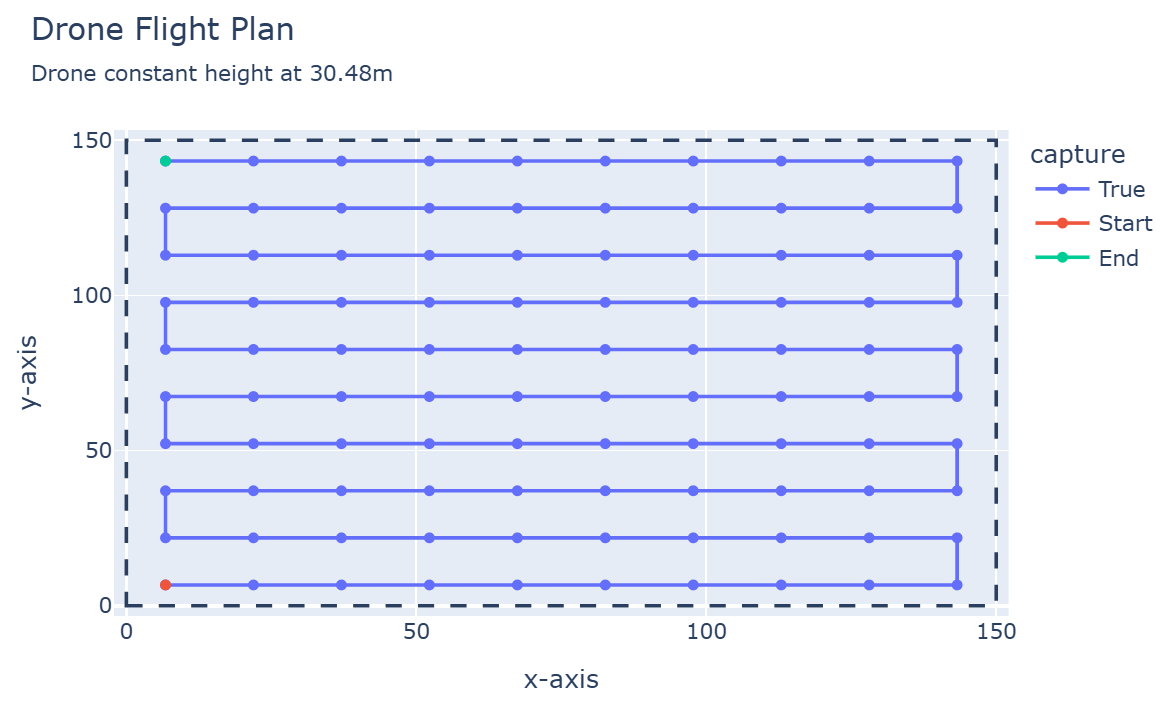